# Notebook for exploring the differences between language styles of posts vs. comments in a r/sciemce 
Specifically: 

-Do the language styles of inside posts and inside comments differ?

-Is there a gap for both of these language styles for those outside of a community?

-These results are reported in Figure 3 and 4 of the paper (to get figure 4, specify the keyword 'first=True' to calc_single_acc_gap_SRILM and calc_acc_gap_SRILM functions

# Get all funcs and LMs


In [4]:
import os
os.chdir('/homes/gws/taugust/ARK/community_guidelines')
%run Reddit/SRILM_building_funcs.ipynb


/homes/gws/taugust/ARK/community_guidelines


## Getting all LMs

In [5]:
%%capture
########################################################################################
### Get all language models 
### this is not where you train them -- we just load them from files
########################################################################################

post_based_slms = build_total_SLM_SRILM(None, None, slm_count=100, name='science', use_saved_lms=True, kind='post', year='2018', full=False);
comment_based_slms = build_monthly_SLM_SRILM(None, None, 100, name='science', use_saved_lms=True, kind='comment', year='2018', full=False);

post_based_slms_full = build_total_SLM_SRILM(None, None, slm_count=100, name='science', use_saved_lms=True, kind='post', year='2018', full=True);
comment_based_slms_full = build_monthly_SLM_SRILM(None, None, 100, name='science', use_saved_lms=True, kind='comment', year='2018', full=True);


## Do outside comments look more similar to inside posts than inside comments are to inside posts?

Here we will start with looking at if outside *comments* are more similar to inside *posts* than inside comments are to inside *posts*

Considering that posts and comments look pretty different in general, both will not be all that close, but ideally we will see that outside comments are closer to inside posts than inside comments are (and that outside comments are closer to inside posts than they are to inside comments)


### Outside comments are closer to inside posts than inside comments are: 

Get entropy of outside and inside *comments* using LMs trained on *posts*, check if outside comments have lower entropy compared to inside comments



# This is the final script for this whole notebook currently
Runs for both comments vs. posts and calculates the acc gap of comments and posts

Importing  data/cleaned/sub_comments/science_comments_2018.csv ..... Done
Importing  data/cleaned/test/2018/author_counts/science_author_counts_test_2018.csv ..... Done
Importing  data/cleaned/sub_posts/science_posts_2018.csv ..... Done
Importing  data/cleaned/test/2018/author_counts/science_author_counts_test_2018.csv ..... Done
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
No month...taking all author counts
sampled active users: 250 sampled outside users: 250
No month...taking all author counts
sampled active comments: 250 sampled outside comments: 250


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
No month...taking all author counts
sampled active users: 250 sampled outside users: 250
No month...taking all author counts
sampled active comments: 250 sampled outside comments: 250
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
No month...taking all author counts
sampled active users: 250 sampled outside users: 250
No month...taking all author counts
sampled active comments: 250 sampled outside comments: 250
Calculating cross entropy for month total .....
No month...taking all author counts
No month...taking all author counts
No month...taking all author counts
sampled active users: 250 sampled outside users: 250
No month...taking all author counts
sampled active comments: 250 sampled outside comments: 250
Calculating cross entropy for month total .....
No month...taking all author counts
No m

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


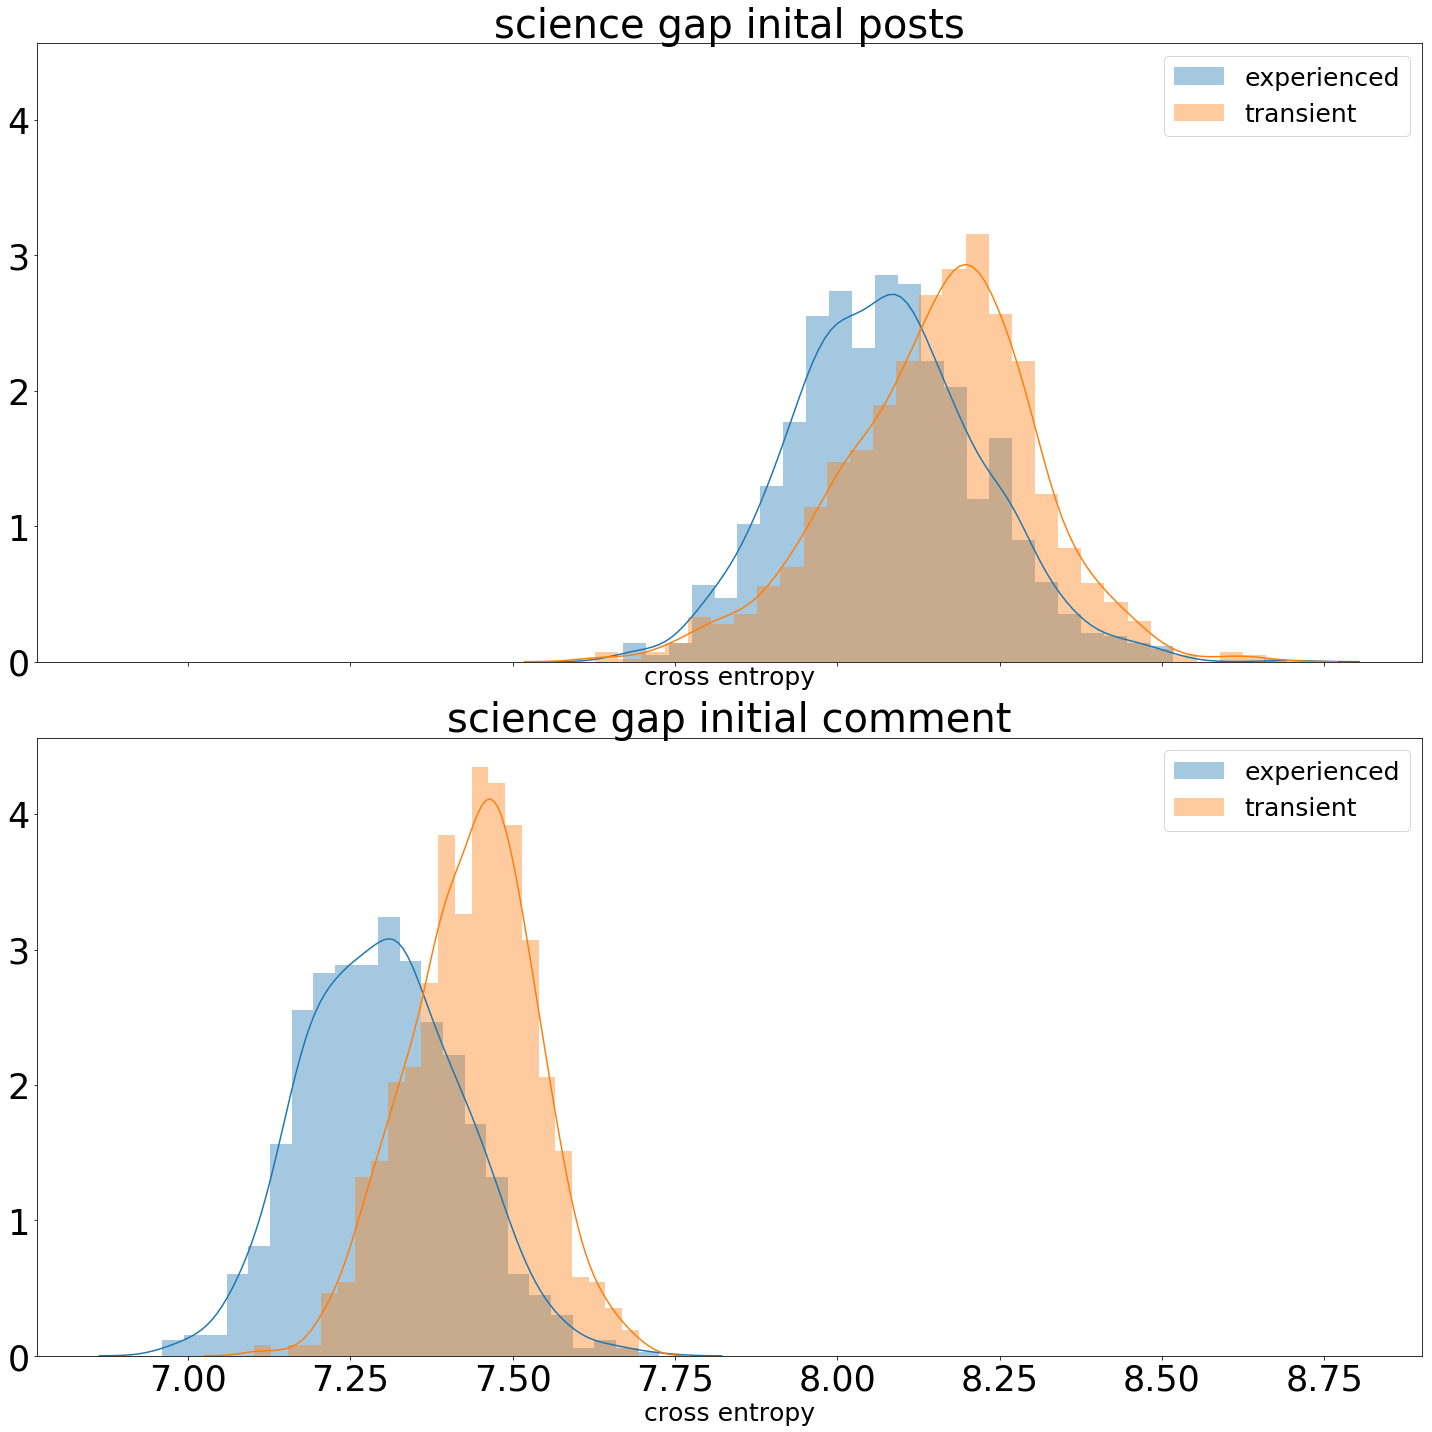

In [11]:
fig_gap, axs_gap = plt.subplots(2, 1, sharey=True, sharex=True, tight_layout=True)
fig_gap.set_figheight(20)
fig_gap.set_figwidth(20)


df_comment_post_gap_list_post_based = []

df_comment_post_gap_list_comment_based = []


t_vals = {s:{'comments':0, 'posts':0, 'gap':0} for s in subs}
p_vals = {s:{'comments':0, 'posts':0, 'gap':0} for s in subs}

all_p_vals = []


subs = ['science']
year='2018'
for i, s in enumerate(subs):
    
    ##### posts 
    df_comments, df_posts, df_author_counts_test = get_df_posts_and_comments(s, year)
    total_acc_gap_posts = []
    entropies_posts = {'inside':[], 'outside':[]}
    
    df_posts_restricted = df_posts[df_posts['created_month'] > 2]
    for i in range(1, 13):
        # Posts #
        ############
        gap_post, (active_ent_post, outside_ent_post) = calc_single_acc_gap_SRILM(post_based_slms, df_author_counts_test, df_posts, s, kind='post', month=None, 
                                            num_active_authors=250, num_active_posts=5, num_outside_authors=250, num_outside_posts=1, first=True)
        total_acc_gap_posts.append(gap_post)
        entropies_posts['inside'].extend(active_ent_post)
        entropies_posts['outside'].extend(outside_ent_post)

    # group inside & outside
    df_posts_inside_outside = pd.DataFrame(entropies_posts)
    df_posts_inside_outside = df_posts_inside_outside.rename(index=str, columns={"inside": "experienced", "outside": "transient"})
    plot_entropy_dist(df_posts_inside_outside, ['experienced', 'transient'],  axs_gap[0], s+' gap inital posts')

    
    t, p = stats.ttest_ind(df_posts_inside_outside['experienced'], df_posts_inside_outside['transient'])
    print('t=', t, 'p=', p)
    t_vals[s]['posts'] = t
    p_vals[s]['posts'] = p
    
    all_p_vals.append(p)
    
        
    #### Comments
    # Just use the full acc gap function to loop through all the months 
    print('Getting avg acc gap for', colored('comments', 'green'), 'with passed slms')
    dict_gap_comments, entropies_comments = calc_acc_gap_SRILM(comment_based_slms, df_author_counts_test, df_comments, s, kind='comment',
                                       num_active_authors=250, num_active_posts=5, num_outside_authors=250, num_outside_posts=1, first=True)

    # group inside & outside
    entropies_comments = {'experienced':list(flatten(entropies_comments['inside'])), 'transient':list(flatten(entropies_comments['outside']))}
    df_comments_inside_outside = pd.DataFrame(entropies_comments)
    plot_entropy_dist(df_comments_inside_outside, ['experienced', 'transient'],  axs_gap[1], s+' gap initial comment')

    t, p = stats.ttest_ind(df_comments_inside_outside['experienced'],df_comments_inside_outside['transient'])
    print('t=', t, 'p=', p)
    t_vals[s]['comments'] = t
    p_vals[s]['comments'] = p
    all_p_vals.append(p)
    

    
fig_gap.savefig('data/figs/gap')


In [33]:
cohens_d(df_comments_inside_outside['experienced'],df_comments_inside_outside['transient'])

-0.7768245736299335

In [29]:
len(df_posts_inside_outside)

1200

In [34]:
# get means and stds
print('posts\n', df_posts_inside_outside.mean(), df_posts_inside_outside.std())
print('comments\n', df_comments_inside_outside.mean(), df_comments_inside_outside.std())

posts
 experienced    8.138832
transient      8.115073
dtype: float64 experienced    0.169622
transient      0.136452
dtype: float64
comments
 experienced    7.300689
transient      7.394837
dtype: float64 experienced    0.131470
transient      0.109968
dtype: float64


In [7]:
# get effect sizes
print('posts\n', cohens_d(df_posts_inside_outside['experienced'], df_posts_inside_outside['first time']))
print('comments\n', cohens_d(df_comments_inside_outside['experienced'], df_comments_inside_outside['first time']))

posts
 -1.2826328023374776
comments
 -1.307321065200458


In [10]:
# get the p_values
p_vals

{'science': {'comments': 0.0, 'posts': 2.4191426881442263e-74, 'gap': 0}}

In [11]:
# adjust for multiple tests
sm.multitest.multipletests([0.0, 2.4191426881442263e-74], alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

(array([ True,  True]),
 array([0.00000000e+00, 2.41914269e-74]),
 0.025320565519103666,
 0.025)

In [6]:
# save the results as csvs
df_comment_post_gap_post_based.to_csv('data/cleaned/df_comment_post_gap_post_based.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
df_comment_post_gap_comment_based.to_csv('data/cleaned/df_comment_post_gap_comment_based.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

,posts,comments
0,7.647456,8.742133
1,7.660437,8.633672
2,7.855144,8.510560
3,7.540261,8.641774
4,7.638434,8.739861
5,7.453131,8.293835
6,7.586657,8.613629
7,7.843629,8.546581
8,7.484609,8.504940
9,7.572335,8.388027


In [ ]:
# save the p_values and t statistics
with open('data/cleaned/t_vals.txt', 'w') as outfile:  
    json.dump(t_vals, outfile)

with open('data/cleaned/p_vals.txt', 'w') as outfile:  
    json.dump(p_vals, outfile)

In [ ]:
print(all_p_vals)